<a href="https://colab.research.google.com/github/dkssud8150/Computer-Vision/blob/main/CustomDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Custom Dataset



## 1-1 https://wikidocs.net/57165

파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 torch.utils.data.Dataset / torch.utils.data.DataLoader 을 제공한다. 

하지만, torch.utils.data.Dataset을 사용하지 않고 custom daaset을 만들기도 한다. 

> 나의 경우 폴더들의 이름이 아닌 다른 내가 원하는 image set과 label set 을 구성하고 싶었다. torch.dataset은 이런 것보다는 정형화된 데이터를 사용할 때 좋다. 예를 들면 mnist, cifar10 과 같은 것들이다.

커스텀 데이터셋을 만들 때, 가장 기본적인 뼈대는 __init__, __len__, __getitem__ 총 3개 이다.

In [ ]:
''' 기본 구조 '''
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self): # 데이터셋의 전처리를 해주는 부분
    
  def __len__(self): # 데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분, len(dataset)을 했을 때 데이터셋의 크기를 리턴할 len

  def __getitem__(self, idx): # 데이터셋에서 특정 1개의 샘플을 가져오는 함수, dataset[i]을 했을 떄 i번째 샘플을 가져오도록 하는 인덱싱을 위함

####  

### 커스텀 데이터셋으로 선형 회귀 구현


In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Dataset 상속
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = [[73, 80, 75],
                   [93, 88, 93],
                   [89, 91, 90],
                   [96, 98, 100],
                   [73, 66, 70]]
    self.y_data = [[152],[185],[180],[196],[142]]


# 총 데이터의 개수 리턴
  def __len__(self):
    return len(self.x_data) # 하나의 [] 안의 데이터의 개수는 상관없이 전체 len을 구하는 듯하다.

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx])
    y = torch.FloatTensor(self.y_data[idx])
    return x,y

In [ ]:
class BinaryClassifier(nn.Module):
  def __init__(self):   
    super().__init__()
    self.linear = nn.Linear(3,1) # (input_dim,output_dim), dim = [ ]안의 개수
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    return self.sigmoid(self.linear(x))

In [ ]:
dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size = 2, shuffle = True)

model = BinaryClassifier()

In [ ]:
# 임의의 입력 [73, 80, 75]로 테스트하면
new_var = torch.FloatTensor([[73, 80, 75]])

# 입력한 값 [73, 80, 75]에 대해서 예측값을 리턴받아서 pred_y에 저장
pred_y = model(new_var)
print("훈련 후 입력이 73, 80, 75 일 때의 예측값 : ", pred_y) # 73,80,75 데이터의 label이 152.29 일 것이라는 예측

훈련 후 입력이 73, 80, 75 일 때의 예측값 :  tensor([[151.4009]], grad_fn=<AddmmBackward>)


##  

## 1-2 https://tutorials.pytorch.kr/beginner/data_loading_tutorial.html

### 사용자 정의 Dataset, Dataloader, Transforms

일반적이지 않은 데이터셋으로부터 데이터를 읽어오고 전처리하는 튜토리얼

dataset download url : https://download.pytorch.org/tutorial/faces.zip 

#### Dataset 클래스

len(dataset) 에서 호츨되는 __len__ 은 데이터셋의 크기를 리턴해야 한다.

dataset[i] 에서 호출되는 __getitem__ 은 i번쨰 샘플을 찾는데 사용된다.

<br>

__init__을 사용하여 CSV 파일 안에 있는 데이터를 읽지만, __getitem__을 이용해서 이미지를 판독해야 한다. 이 방법은 모든 이미지를 메모리에 저장하지 않고 필요할때마다 읽기 때문에 메모리에 효율적이다.

데이터 샘플은 {'image': image, 'landmarks': landmarks}의 사전 형태를 갖는다. 

In [18]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
from skimage.transform import rescale, resize
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import cv2

import warnings
warnings.filterwarnings("ignore")

plt.ion() # 반응형 모드

In [3]:
class FaceLandmarksDataset(Dataset):
  """ Face Landmarks dataset """
  
  def __init__(self, csv_file, root_dir, transform = None):
    """ Args:
              csv_file (string): csv 파일 경로
              root_dir (string): 모든 이미지가 존재하는 디렉토리 경로
              transform (callable): 샘플에 적용할 optional transform
    """
    self.landmarks_frame = pd.read_csv(csv_file)  # csv_file을 불러온다.
    self.root_dir = root_dir                      # 모든 이미지가 존재하는 디렉토리 
    self.transform = transform

  def __len__(self):
    return len(self.landmarks_frame)              # 데이터의 개수, 즉 image 개수라고 할 수 있다.

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()                          # idx가 tensor이면 list로 바꾼다.

    img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0]) # root_dir 안의 csv_file에서 모든 이미지를 불러와 할당
    image = io.imread(img_name)                   # 이미지 읽기

    landmarks = self.landmarks_frame.iloc[idx, 1:]      # csv_file에서 각 idx 마다의 데이터들을 다 불러온다.
    landmarks = np.array([landmarks])                   # reshape를 위해 list가 아닌 numpy
    landmarks = landmarks.astype('float').reshape(-1,2) # (k,2) 배열로 변환
    sample = {'image': image, 'landmarks': landmarks}   # 각 image와 landmarks(keypoint)를 연결

    if self.transform:
      sample = self.transform(sample)
    
    return sample

In [4]:
''' landmark를 보기 위한 함수 '''
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    """ 랜드마크(landmark)와 이미지를 보여줍니다. """
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # 갱신이 되도록 잠시 멈춥니다.

number: 0 	 image shape: (324, 215, 3) 	 label shape: (68, 2) 
 len image: 324 	 len label: 68


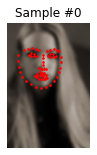

number: 1 	 image shape: (500, 333, 3) 	 label shape: (68, 2) 
 len image: 500 	 len label: 68


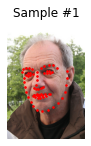

number: 2 	 image shape: (250, 258, 3) 	 label shape: (68, 2) 
 len image: 250 	 len label: 68


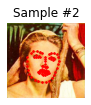

number: 3 	 image shape: (434, 290, 3) 	 label shape: (68, 2) 
 len image: 434 	 len label: 68


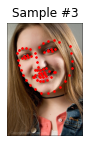

In [42]:
face_dataset = FaceLandmarksDataset(csv_file = '/content/drive/MyDrive/data/faces/face_landmarks.csv',
                                   root_dir = '/content/drive/MyDrive/data/faces/') # __init__ 에 대한 args들을 받으면 len, getitem을 계산해놓고, 추후에 len이나 dataset[i]를 실행하면 리턴해줌

fig = plt.figure()

for i in range(len(face_dataset)):
  sample = face_dataset[i] # i만큼 idx를 지정

  print("number: {} \t image shape: {} \t label shape: {} \n len image: {} \t len label: {}"
        .format(i, sample['image'].shape, sample['landmarks'].shape, len(sample['image']),len(sample['landmarks'])))
  ''' 
      image - 1개의 이미지에 대해 324 row(높이) x 215 col(넓이) x 3 dim(RGB)
      label - 총 68개의 landmarks(keypoint) 68 row x 2 col
  '''

  ax = plt.subplot(1, 4, i+1)
  plt.tight_layout()
  ax.set_title('Sample #{}'.format(i))
  ax.axis('off')
  show_landmarks(**sample) # **sample = io.imread(os.path.join('/content/drive/MyDrive/data/faces', img_name)),landmarks

  if i == 3:
    plt.show()
    break

Q. 왜 landmarks shape이 (68,2)가 되어야 하지?
> 데이터가 columns를 보면 x,y가 존재한다. 따라서 1개의 landmark(keypoint)를 표현하기 위해 x,y값을 묶어야 한다. => 묶어서 보았을 때 이미지 상에 총 68개 keypoint가 존재한다.

Q. image와 label의 size를 맞춰야 하는 것 아닌가?
> 지금 출력하고 있는 것은 각각의 이미지의 _height x weight x depth_ 이다. 따라서 총 이미지 크기가 아니기 때문에 맞지 않았던 것이다. 총 images 들의 len과 labels 들의 len은 맞는다.


#### Transform 클래스

샘플들을 data augmentation 시킨다.

- rescale: 이미지의 크기를 조절
- randomCrop: 무작위 자르기, data augmentation
- ToTensor: numpy이미지를 torch이미지로 변경( 축 변환 )

클래스를 작성할 때는 __call__ 함수를 구현해야 한다. 필요하다면 __init__ 함수도 구현해야 한다.

In [74]:
class Rescale(object):
  '''
  주어진 사이즈로 샘플 크기 조정

  Args: output size(tuple or int): 원하는 사이즈 값
                                   tuple인 경우 해당 tuple이 결과물의 크기가 되고, 
                                   int라면 비율을 유지하면서 길이가 작은 쪽이 output size가 된다.
  '''

  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))    # assert = 뒤의 조건이 True 가 아니면 에러를 발생시킨다. output size가 int나 tuple 타입이면 true
    self.output_size = output_size

  def __call__(self,sample):
    image, landmarks = sample['image'], sample['landmarks']

    h, w = image.shape[:2]                # 각 image.shape는 [h,w,c] 로 구성되어 있다. 따라서 2번째까지만 추출
    if isinstance(self.output_size, int): # args - output_size가 int라면
      if h > w:                           # h/w 비율을 곱하여 new_h가 더 큰 값이 되도록
        new_h, new_w = self.output_size * h / w, self.output_size 
      else:
        new_h, new_w = self.output_size, self.output_size * w / h
    
    else:                                 # tuple이라면 그대로 출력
      new_h, new_w = self.output_size
    

    new_h, new_w = int(new_h), int(new_w)           # 크기는 int로 출력해야 되기에

    img = cv2.resize(image, (new_h, new_w))   # image를 내가 원하는 사이즈의 값으로 크기 조정
    
    # print("landmarks data: {} \nlandmarks shape: {} \nnew_w data: {} \nnew_h data: {}".format(landmarks, landmarks.shape, new_w, new_h) )

    landmarks = landmarks * [ new_w / w, new_h / h ]

    return {'image': img, 'landmarks': landmarks}

class RandomCrop(object):
  '''
  샘플데이터를 무작위로 자름

  Args: output_size (tuple or int): 줄이고자 하는 크기로 int면 정사각형, tuple이라면 지정된 크기로
  '''

  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    if isinstance(output_size, int):                # int
      self.output_size = (output_size, output_size)  # 그대로
    else:                                           # tuple
      assert len(output_size) == 2                  # size가 2일때만
      self.output_size = output_size

  def __call__(self, sample):
    image, landmarks = sample['image'], sample['landmarks']

    h, w = image.shape[:2]                        # 256 이라고 하면
    new_h, new_w = self.output_size               # new = 224,224
    
    top = np.random.randint(0, h - new_h)         # (0 ~ (256 - 224)) 값 사이의 random추출
    left = np.random.randint(0, w - new_w)        # 원본을 넘게 자르도록 설정되지 않도록 하기 위함
    
    image = image[top: top + new_h,               # image의 높이를 새로 설정한 크기와 random하게 추출한 값을 더함
                  left: left + new_w]             # 원본보다는 무조건 작거나 같다.
    
    landmarks = landmarks - [left,top]            # keypoint의 위치도 left,top을 뺌


    return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
  '''
  numpy array를 tensor(torch)로 변환
  '''

  def __call__(self,sample):
    image, landmarks = sample['image'], sample['landmarks']

    # swap color axis ( numpy image: HxWxC => torch image: CxHxW )
    image = image.transpose((2,0,1))
    
    return {'image':torch.from_numpy(image),
            'landmarks':torch.from_numpy(landmarks)}


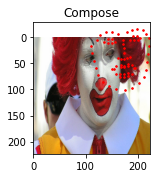

In [82]:
transform = transforms.Compose([Rescale(256),
                                RandomCrop(224)])   # output_size = 256,256  # output_size = 224,224

fig = plt.figure()
sample = face_dataset[60]
for i in range(1):
  image_transforms = transform(sample)

  ax = plt.subplot(1,3,i+1)
  plt.tight_layout()
  ax.set_title(type(transform).__name__)
  show_landmarks(**image_transforms)

plt.show()

transformed_dataset = FaceLandmarksDataset(csv_file = '/content/drive/MyDrive/data/faces/face_landmarks.csv',
                                          root_dir = '/content/drive/MyDrive/data/faces/',
                                          transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

Q. landmark에다 new_w/w,new_h를 왜 곱하는걸까
> landmarks data가 각 keypoint의 좌표를 찍어놓은 것이기 때문에 landmark 데이터에도 비율만큼 곱해줘야 맞는 위치를 찍을 수 있다.

Q. crop 할 때 왜 224가 output_size가 되야 할텐데 top+new_w를 하면 224가 무조건 나오는 건 아니지 않나. 이름만 output_size인가
> 일단 음,, 실행이 되지 않음

#### Dataloader 클래스

torch.utils.data.DataLoader를 사용하면 반복자(iterator)로서 많은 기능을 해준다. 


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


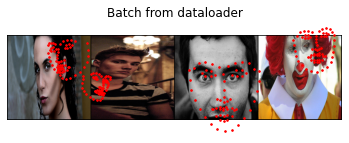

In [87]:
dataloader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=0)

# 배치하는 과정을 보여주는 함수입니다.
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i, batched_sample in enumerate(dataloader):
  print(i, batched_sample['image'].size(), batched_sample['landmarks'].size()) 

  if i == 3:
    plt.figure()
    show_landmarks_batch(batched_sample)
    plt.axis('off')
    plt.ioff()
    plt.show()
    break